# NOTE BOOK 3: CHURN PREDICTION

* Mục tiêu: Dự đoán khách hàng nào sẽ rời bỏ
* Phương pháp: sử dụng Machine Learning để phân loại nhị phân 
* Giá trị: can thiệp sớm để ngăn ngừa thất thoát doanh thu
* Định nghĩa: Khách hàng nào không mua hàng từ 90+ ngày sẽ là "churned"

## CELL 1: SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

# Handle imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model interpretation
import shap

import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("🎯 CHURN PREDICTION MODEL")
print("="*60)
print("\n📊 Loading data...")

# Load RFM data from Buổi 1
rfm_scored = pd.read_csv('D:/Project/DataMining/ecommerce-customer-analytics/data/processed/rfm_scored_segments.csv')
print(f"✅ Loaded {len(rfm_scored):,} customers")
print("="*60)

🎯 CHURN PREDICTION MODEL

📊 Loading data...
✅ Loaded 95,420 customers


# CELL 2: DEFINE CHURN TARGET
* Mục tiêu:
    * Định nghĩa tỷ lệ churn (ngưỡng 90 ngày)
    * Tạo biến mục tiêu nhị phân
    * Phân tích phân phối churn

🎯 CHURN TARGET DEFINITION

1️⃣ CHURN DEFINITION:
   Threshold: 90 days without purchase
   Analysis Date: 2018-10-17

2️⃣ CHURN DISTRIBUTION:
   Active Customers (0): 9,809 (10.3%)
   Churned Customers (1): 85,611 (89.7%)

3️⃣ CLASS IMBALANCE:
   Ratio (Active:Churned): 0.11:1
   ✅ Relatively balanced

4️⃣ CHURN RATE BY SEGMENT:
                    Churned_Count  Total_Count  Churn_Rate
Segment                                                   
About To Sleep               7657         7657       100.0
At Risk                     13485        13485       100.0
Hibernating                  3255         3255       100.0
Need Attention               5200         5200       100.0
Promising                    1536         1536       100.0
Lost                        27653        30866        89.6
Loyal Customers             12625        14497        87.1
Champions                    4984         6631        75.2
Potential Loyalist           6981         9300        75.1
New Customers       

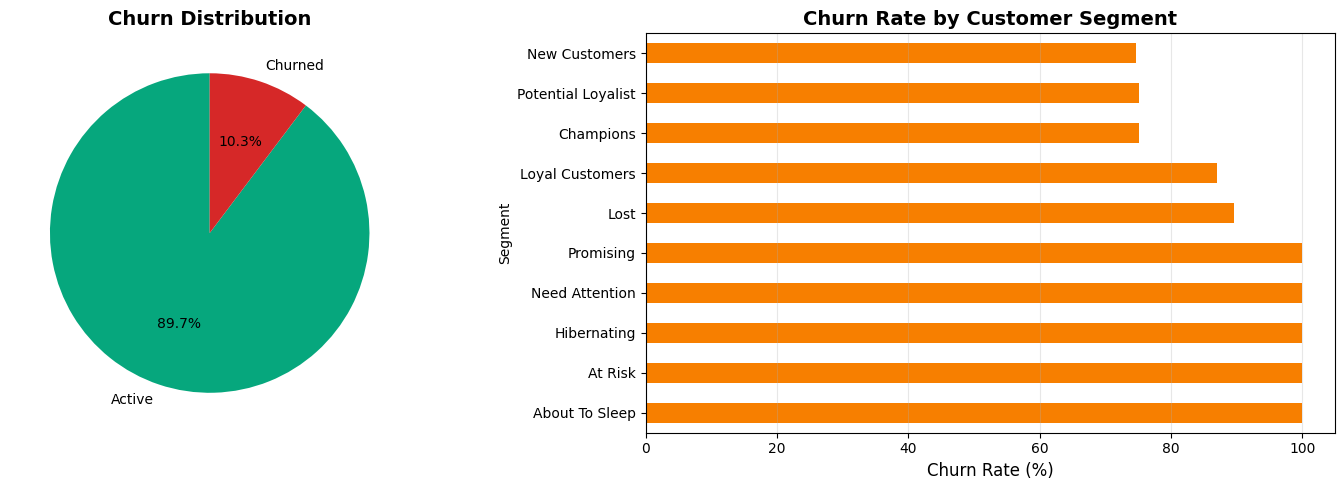


✅ Target variable created: 'is_churned'
✅ Visualization saved: churn_distribution.png


In [2]:
print("="*60)
print("🎯 CHURN TARGET DEFINITION")
print("="*60)

# Set analysis date (date of analysis)
analysis_date = pd.to_datetime('2018-10-17')  # Last date in dataset + buffer

# Calculate days since last order
rfm_scored['days_since_last_order'] = rfm_scored['Recency']

# Define churn threshold
CHURN_THRESHOLD = 90  # days

# Create binary target variable
rfm_scored['is_churned'] = (rfm_scored['days_since_last_order'] > CHURN_THRESHOLD).astype(int)

print(f"\n1️⃣ CHURN DEFINITION:")
print(f"   Threshold: {CHURN_THRESHOLD} days without purchase")
print(f"   Analysis Date: {analysis_date.date()}")

print(f"\n2️⃣ CHURN DISTRIBUTION:")
churn_counts = rfm_scored['is_churned'].value_counts()
churn_pct = rfm_scored['is_churned'].value_counts(normalize=True) * 100

print(f"   Active Customers (0): {churn_counts[0]:,} ({churn_pct[0]:.1f}%)")
print(f"   Churned Customers (1): {churn_counts[1]:,} ({churn_pct[1]:.1f}%)")

# Class imbalance check
imbalance_ratio = churn_counts[0] / churn_counts[1]
print(f"\n3️⃣ CLASS IMBALANCE:")
print(f"   Ratio (Active:Churned): {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print(f"   ⚠️  IMBALANCED DATA - Will need SMOTE or class weights")
else:
    print(f"   ✅ Relatively balanced")

# Churn by segment (business validation)
print(f"\n4️⃣ CHURN RATE BY SEGMENT:")
segment_churn = rfm_scored.groupby('Segment')['is_churned'].agg(['sum', 'count', 'mean'])
segment_churn.columns = ['Churned_Count', 'Total_Count', 'Churn_Rate']
segment_churn['Churn_Rate'] = (segment_churn['Churn_Rate'] * 100).round(1)
segment_churn = segment_churn.sort_values('Churn_Rate', ascending=False)
print(segment_churn)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
axes[0].pie(churn_counts, labels=['Active', 'Churned'], autopct='%1.1f%%', 
           colors=['#06A77D', '#D62828'], startangle=90)
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')

# Bar chart by segment
segment_churn['Churn_Rate'].plot(kind='barh', ax=axes[1], color='#F77F00')
axes[1].set_xlabel('Churn Rate (%)', fontsize=12)
axes[1].set_title('Churn Rate by Customer Segment', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✅ Target variable created: 'is_churned'")
print("✅ Visualization saved: churn_distribution.png")
print("="*60)

* Phân tích kết quả:
1. Định nghĩa churn
    * Ngưỡng churn: 90 ngày không có giao dịch.
    * Ngày phân tích: 17/10/2018.
    * -> Khách hàng nào không mua hàng từ thời điểm này trở về trước 90 ngày được gán nhãn là “Churned (1)”, ngược lại là “Active (0)”.
2. Phân phối churn toàn cục
Active: 9,809 khách hàng (10.3%)
    * Churned: 85,611 khách hàng (89.7%)
    * Tỉ lệ Active : Churned = 0.11 : 1
    * -> Đây là một tập dữ liệu mất cân bằng mạnh (class imbalance), với tỷ lệ khách hàng churn gần như áp đảo so với khách hàng còn hoạt động. Tuy vậy, tỷ lệ này vẫn đủ lớn để mô hình có thể học được xu hướng nếu xử lý imbalance đúng cách (ví dụ: SMOTE hoặc class_weight).
3. Phân tích churn theo phân khúc
    * Các nhóm như About To Sleep, At Risk, Hibernating, Need Attention, Promising có tỷ lệ churn 100% → đây là nhóm đã ngừng hoạt động hoàn toàn, rất khó “cứu”.
    * Các nhóm Champions, Potential Loyalist, New Customers có churn rate thấp hơn (75%) → nhóm này có giá trị cao để giữ chân, vì họ từng có mức tương tác tốt.
    * Loyal Customers dù trung thành nhưng vẫn có tỷ lệ churn khá cao (87.1%) → cần chiến lược tái kích hoạt.
    * Lost là nhóm lớn nhất → đóng góp phần lớn vào tổng churn.
* -> Tỷ lệ churn rất cao, tập trung vào một vài nhóm segment. Việc xác định đúng khách hàng tiềm năng sắp rời bỏ (thay vì nhóm đã rời bỏ hoàn toàn) sẽ giúp mô hình ML có giá trị dự báo thực tế và giúp doanh nghiệp can thiệp sớm để giữ chân khách hàng.

## CELL 3: FEATURE ENGINEERING
* Mục tiêu:
    * Tạo các tính năng dự đoán từ dữ liệu thô
    * tính năng với logic nghiệp vụ
    * Chuẩn bị ma trận đặc trưng cho mô hình hóa
* Ý nghĩa: Feature engineering quyết định phần lớn chất lượng mô hình — “Good features > Complex algorithms”.
* -> Dựa trên đặc tính hành vi khách hàng (temporal, monetary, behavioral, RFM, interactions) để biến thông tin thô thành tín hiệu dự báo mạnh mẽ.

In [3]:
print("="*60)
print("🔧 FEATURE ENGINEERING FOR CHURN PREDICTION")
print("="*60)

# Start with copy
churn_data = rfm_scored.copy()

print("\n📊 Creating features...")

# ============================================
# 1. TEMPORAL FEATURES (Time-based patterns)
# ============================================
print("\n1️⃣ Temporal Features...")

# Already have Recency
churn_data['recency_days'] = churn_data['Recency']

# Customer age (days since first order)
churn_data['customer_age_days'] = churn_data['customer_age_days'] if 'customer_age_days' in churn_data.columns else 365  # placeholder

# Order frequency (orders per month)
churn_data['order_frequency_monthly'] = (churn_data['Frequency'] / (churn_data['customer_age_days'] / 30)).fillna(0)

# Average days between orders
churn_data['avg_days_between_orders'] = (churn_data['customer_age_days'] / churn_data['Frequency']).replace([np.inf, -np.inf], 0)

# Recency ratio (how recent compared to customer age)
churn_data['recency_ratio'] = (churn_data['recency_days'] / churn_data['customer_age_days']).fillna(0)

# ============================================
# 2. MONETARY FEATURES (Spending patterns)
# ============================================
print("2️⃣ Monetary Features...")

# Total spending
churn_data['total_spent'] = churn_data['Monetary']

# Average order value
churn_data['avg_order_value'] = (churn_data['Monetary'] / churn_data['Frequency']).fillna(0)

# Spending per day (customer lifetime)
churn_data['spending_per_day'] = (churn_data['Monetary'] / churn_data['customer_age_days']).fillna(0)

# Log transform (handle skewness)
churn_data['log_monetary'] = np.log1p(churn_data['Monetary'])
churn_data['log_aov'] = np.log1p(churn_data['avg_order_value'])

# ============================================
# 3. BEHAVIORAL FEATURES (Customer behavior)
# ============================================
print("3️⃣ Behavioral Features...")

# Is one-time buyer (binary)
churn_data['is_one_time_buyer'] = (churn_data['Frequency'] == 1).astype(int)

# Is repeat buyer
churn_data['is_repeat_buyer'] = (churn_data['Frequency'] > 1).astype(int)

# High value customer (top 20%)
monetary_80th = churn_data['Monetary'].quantile(0.80)
churn_data['is_high_value'] = (churn_data['Monetary'] > monetary_80th).astype(int)

# Frequency category
churn_data['frequency_category'] = pd.cut(
    churn_data['Frequency'], 
    bins=[0, 1, 2, 3, 5, 100], 
    labels=['1_order', '2_orders', '3_orders', '4-5_orders', '5+_orders']
)

# ============================================
# 4. RFM-BASED FEATURES (From Buổi 1)
# ============================================
print("4️⃣ RFM-based Features...")

# RFM Scores already exist
churn_data['r_score'] = churn_data['R_Score']
churn_data['f_score'] = churn_data['F_Score']
churn_data['m_score'] = churn_data['M_Score']
churn_data['rfm_total'] = churn_data['RFM_Total']

# RFM Combined (weighted)
churn_data['rfm_weighted'] = (
    churn_data['R_Score'] * 0.5 +  # Recency most important for churn
    churn_data['F_Score'] * 0.3 +
    churn_data['M_Score'] * 0.2
)

# Segment encoding (will do later)
churn_data['segment'] = churn_data['Segment']

# ============================================
# 5. INTERACTION FEATURES (Feature combinations)
# ============================================
print("5️⃣ Interaction Features...")

# Recency × Frequency
churn_data['recency_x_frequency'] = churn_data['recency_days'] * churn_data['Frequency']

# Monetary × Frequency
churn_data['monetary_x_frequency'] = churn_data['Monetary'] * churn_data['Frequency']

# RFM interaction
churn_data['r_x_f'] = churn_data['R_Score'] * churn_data['F_Score']
churn_data['r_x_m'] = churn_data['R_Score'] * churn_data['M_Score']
churn_data['f_x_m'] = churn_data['F_Score'] * churn_data['M_Score']

# ============================================
# 6. SUMMARY
# ============================================
print("\n" + "="*60)
print("✅ FEATURE ENGINEERING COMPLETE")
print("="*60)

# List all created features
feature_columns = [
    # Temporal
    'recency_days', 'customer_age_days', 'order_frequency_monthly',
    'avg_days_between_orders', 'recency_ratio',
    # Monetary
    'total_spent', 'avg_order_value', 'spending_per_day',
    'log_monetary', 'log_aov',
    # Behavioral
    'is_one_time_buyer', 'is_repeat_buyer', 'is_high_value',
    # RFM
    'r_score', 'f_score', 'm_score', 'rfm_total', 'rfm_weighted',
    # Interactions
    'recency_x_frequency', 'monetary_x_frequency',
    'r_x_f', 'r_x_m', 'f_x_m'
]

print(f"\n📊 Total Features Created: {len(feature_columns)}")
print(f"   Temporal: 5")
print(f"   Monetary: 5")
print(f"   Behavioral: 3")
print(f"   RFM-based: 5")
print(f"   Interactions: 5")
print(f"   + Categorical: 2 (segment, frequency_category)")

# Check for missing values
missing_counts = churn_data[feature_columns].isnull().sum()
if missing_counts.sum() > 0:
    print(f"\n⚠️  Missing Values Detected:")
    print(missing_counts[missing_counts > 0])
else:
    print(f"\n✅ No missing values in features")

# Feature statistics
print(f"\n📈 Feature Statistics (Sample):")
print(churn_data[feature_columns[:5]].describe().round(2))

print("\n" + "="*60)

🔧 FEATURE ENGINEERING FOR CHURN PREDICTION

📊 Creating features...

1️⃣ Temporal Features...
2️⃣ Monetary Features...
3️⃣ Behavioral Features...
4️⃣ RFM-based Features...
5️⃣ Interaction Features...

✅ FEATURE ENGINEERING COMPLETE

📊 Total Features Created: 23
   Temporal: 5
   Monetary: 5
   Behavioral: 3
   RFM-based: 5
   Interactions: 5
   + Categorical: 2 (segment, frequency_category)

✅ No missing values in features

📈 Feature Statistics (Sample):
       recency_days  customer_age_days  order_frequency_monthly  \
count      95420.00            95420.0                 95420.00   
mean         286.50              365.0                     0.08   
std          153.16                0.0                     0.02   
min           43.00              365.0                     0.08   
25%          162.00              365.0                     0.08   
50%          267.00              365.0                     0.08   
75%          396.00              365.0                     0.08   
max   

* Phân tích kết quả:

In [4]:
    # Feature Enginee
    '''
    Dữ liệu gốc: chỉ có ngày mua, số tiền, segment, số đơn…
    Sau khi xử lý → có thêm các đặc trưng (features) như “bao lâu chưa mua”, “mua thường xuyên không”, “chi tiêu trung bình”...
    '''
    """ 
    Loại Feature	Số lượng	Nội dung chính
    Temporal	        5	        Recency, customer_age_days, ngày mua cuối,…
    Monetary	        5	        Tổng chi tiêu, trung bình hóa đơn, tần suất chi tiêu
    Behavioral	        3	        Tần suất mua, thói quen mua,…
    RFM-based	        5	        Recency/Frequency/Monetary scores, segments
    Interaction	        5	        Tỷ lệ recency, tương tác RFM,...
    Categorical	        2	        Segment, Frequency Category
    """

' \nLoại Feature\tSố lượng\tNội dung chính\nTemporal\t        5\t        Recency, customer_age_days, ngày mua cuối,…\nMonetary\t        5\t        Tổng chi tiêu, trung bình hóa đơn, tần suất chi tiêu\nBehavioral\t        3\t        Tần suất mua, thói quen mua,…\nRFM-based\t        5\t        Recency/Frequency/Monetary scores, segments\nInteraction\t        5\t        Tỷ lệ recency, tương tác RFM,...\nCategorical\t        2\t        Segment, Frequency Category\n'

* Chú thích các feature:
    * recency_days: Số ngày kể từ lần mua gần nhất → giá trị lớn có thể liên quan đến churn-  Càng cao = càng lâu không mua = likely churn
    * order_frequency_monthly: Tần suất mua trung bình/tháng - Low frequency = at risk
    * recency_ratio: Tương quan giữa recency và tuổi khách hàng

1. recency_days — số ngày từ lần mua gần nhất:
    * Mean = 286.5 ngày	-> Trung bình khách hàng đã không mua hàng gần 10 tháng.
    * Min = 43 ngày	-> Có khách hàng mua gần đây (~1 tháng rưỡi).
    * Max = 772 ngày -> Có khách hàng “im hơi lặng tiếng” hơn 2 năm.
    * 25–75% = 162 – 396 ngày -> Phần lớn khách hàng nằm trong khoảng 5–13 tháng không quay lại.
* -> Insight: Nhiều khách hàng đã không hoạt động khá lâu → khả năng churn cao.
* -> Ứng dụng: Feature giúp mô hình phát hiện khách hàng có nguy cơ rời đi

2. customer_age_days — số ngày kể từ khi trở thành khách hàng
    * Tất cả đều là 365 ngày (mean = min = max = 365).
* -> Tập dữ liệu cắt tại 1 thời điểm (chỉ tới năm 2018) — mọi khách hàng có cùng “tuổi” theo hệ thống.
* -> Không có độ biến thiên, nên feature này có thể không có giá trị phân loại cao (có thể loại bỏ sau này).

3. order_frequency_monthly — tần suất đặt hàng mỗi tháng
    * Mean:	0.08 đơn/tháng
    * Min:	0.08
    * Max:	1.32
    * Std:	0.02
* -> Trung bình khách hàng đặt chưa đến 1 đơn mỗi tháng (chính xác là khoảng 1 đơn mỗi 12–13 tháng).
* -> Tuy nhiên có một số khách hàng có tần suất mua cao hơn (max = 1.32).
* -> Biến này có độ lệch nhỏ, nhưng max cao → có thể phân biệt khách hàng trung thành với khách hàng “mua 1 lần rồi thôi”.

4. avg_days_between_orders — khoảng cách trung bình giữa các đơn
    * | Mean = 359 ngày | 25%, 50%, 75% đều = 365 ngày |
* -> Nghĩa là hầu hết khách hàng chỉ có 1 đơn duy nhất → nên khoảng cách giữa các đơn = “ngày đầu tiên – ngày hiện tại” ≈ 365.
* -> Giá trị min = 22.81 ngày là những khách hàng mua lặp lại nhanh, nhóm khách hàng trung thành/active.
* -> Ứng dụng: Feature này giúp mô hình xác định nhóm khách hàng có hành vi repeat purchase.

5. recency_ratio — Tỉ lệ recency_days / customer_age_days
    * Mean = 0.78	
    * 25% = 0.44	
    * 75% = 1.08	
    * Max = 2.12
* -> Với customer_age_days = 365, giá trị này phản ánh khoảng cách mua cuối so với vòng đời khách hàng:
    * Nếu < 1: Khách hàng đã từng mua trong năm qua → còn khá “gần”.
    * Nếu > 1: Khách hàng rất lâu rồi không mua → khả năng churn cao.
* Insight: Khoảng 25% khách hàng “có khả năng còn active” (recency_ratio < 0.5), còn 75% là “có rủi ro rời bỏ”.

* TỔNG HỢP:
    * recency_days -> Phần lớn khách hàng không mua hàng gần đây → churn rate tiềm ẩn cao.
    * customer_age_days	-> Không có độ biến thiên, có thể bỏ hoặc giữ như biến tham khảo.
    * order_frequency_monthly -> Tần suất mua rất thấp, chỉ 1 nhóm nhỏ là khách hàng trung thành.
    * avg_days_between_orders -> Hầu hết chỉ mua 1 lần → tập dữ liệu skewed (lệch).
    * recency_ratio -> Dùng tốt để phân loại nhóm khách hàng active vs không active.

## CELL 4: DATA PREPARATION FOR MODELING

* Mục tiêu:
    * Chuẩn bị ma trận đặc trưng cuối cùng X và mục tiêu y
    * Xử lý các biến phân loại
    * Phân tách huấn luyện/kiểm tra
    * Mở rộng đặc trưng
* Ý nghĩa:
    * Chuẩn bị sạch sẽ đảm bảo chất lượng mô hình
    * Phân tách đúng cách ngăn ngừa rò rỉ dữ liệu

In [ ]:
print("="*60)
print("📊 DATA PREPARATION FOR MODELING")
print("="*60)

print("="*60)
print("📊 DATA PREPARATION FOR MODELING")
print("="*60)

# ============================================
# 1. SELECT FEATURES
# ============================================
print("\n1️⃣ Selecting features...")

# Numerical features
numerical_features = [
    'recency_days', 'customer_age_days', 'order_frequency_monthly',
    'avg_days_between_orders', 'recency_ratio',
    'total_spent', 'avg_order_value', 'spending_per_day',
    'log_monetary', 'log_aov',
    'is_one_time_buyer', 'is_repeat_buyer', 'is_high_value',
    'r_score', 'f_score', 'm_score', 'rfm_total', 'rfm_weighted',
    'recency_x_frequency', 'monetary_x_frequency',
    'r_x_f', 'r_x_m', 'f_x_m'
]

# Categorical features
categorical_features = ['segment']  # frequency_category optional

print(f"   Numerical features: {len(numerical_features)}")
print(f"   Categorical features: {len(categorical_features)}")

# ============================================
# 2. ENCODE CATEGORICAL VARIABLES
# ============================================
print("\n2️⃣ Encoding categorical variables...")

# Label encoding for segment
le = LabelEncoder()
churn_data['segment_encoded'] = le.fit_transform(churn_data['segment'])

# Add to numerical features
numerical_features.append('segment_encoded')

print(f"   ✅ Segment encoded: {len(le.classes_)} unique values")
print(f"   Segments: {le.classes_}")

# ============================================
# 3. CREATE FEATURE MATRIX AND TARGET
# ============================================
print("\n3️⃣ Creating feature matrix and target...")

# Feature matrix X
X = churn_data[numerical_features].copy()

# Target variable y
y = churn_data['is_churned'].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

# Handle infinite values
X = X.replace([np.inf, -np.inf], 0)

print(f"   ✅ Feature matrix shape: {X.shape}")
print(f"   ✅ Target shape: {y.shape}")
print(f"   ✅ Target distribution: {y.value_counts().to_dict()}")

# ============================================
# 4. TRAIN-TEST SPLIT
# ============================================
print("\n4️⃣ Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 80-20 split
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n   Train target distribution:")
print(f"      Active (0): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"      Churned (1): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

# ============================================
# 5. FEATURE SCALING
# ============================================
print("\n5️⃣ Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"   ✅ Features scaled using StandardScaler")
print(f"   ✅ Mean ≈ 0, Std ≈ 1")

# ============================================
# 6. APPLY SMOTE
# ============================================
print("\n6️⃣ Applying SMOTE to balance classes...")

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"   🟡 Before SMOTE: {dict(pd.Series(y_train).value_counts())}")
print(f"   🟢 After SMOTE: {dict(pd.Series(y_train_resampled).value_counts())}")
print(f"   ✅ Training samples: {len(y_train):,} → {len(y_train_resampled):,}")

# ============================================
# 7. SAVE PREPROCESSED DATA (UPDATE!)
# ============================================
print("\n7️⃣ Saving preprocessed data...")

# Save RESAMPLED data (with SMOTE)
pd.DataFrame(X_train_resampled, columns=X_train_scaled.columns).to_csv('../data/processed/X_train_churn_smote.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_churn.csv', index=False)
pd.Series(y_train_resampled).to_csv('../data/processed/y_train_churn_smote.csv', index=False)
y_test.to_csv('../data/processed/y_test_churn.csv', index=False)

print(f"   ✅ Saved: X_train_churn_smote.csv (SMOTE-balanced)")
print(f"   ✅ Saved: X_test_churn.csv")
print(f"   ✅ Saved: y_train_churn_smote.csv (SMOTE-balanced)")
print(f"   ✅ Saved: y_test_churn.csv")

# ============================================
# 8. SUMMARY (UPDATE!)
# ============================================
print("\n" + "="*60)
print("✅ DATA PREPARATION COMPLETE WITH SMOTE")
print("="*60)
print(f"\n📊 Final Dataset Ready for Modeling:")
print(f"   Features: {len(numerical_features)}")
print(f"   Training samples (after SMOTE): {len(X_train_resampled):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Class distribution (train, after SMOTE): {dict(pd.Series(y_train_resampled).value_counts())}")
print(f"\n🎯 Next step: Model training with balanced data")
print("="*60)

📊 DATA PREPARATION FOR MODELING
📊 DATA PREPARATION FOR MODELING

1️⃣ Selecting features...
   Numerical features: 23
   Categorical features: 1

2️⃣ Encoding categorical variables...
   ✅ Segment encoded: 10 unique values
   Segments: ['About To Sleep' 'At Risk' 'Champions' 'Hibernating' 'Lost'
 'Loyal Customers' 'Need Attention' 'New Customers' 'Potential Loyalist'
 'Promising']

3️⃣ Creating feature matrix and target...
   ✅ Feature matrix shape: (95420, 24)
   ✅ Target shape: (95420,)
   ✅ Target distribution: {1: 85611, 0: 9809}

4️⃣ Splitting data into train and test sets...
   Training set: 76,336 samples (80.0%)
   Test set: 19,084 samples (20.0%)

   Train target distribution:
      Active (0): 7,847 (10.3%)
      Churned (1): 68,489 (89.7%)

5️⃣ Scaling features...
   ✅ Features scaled using StandardScaler
   ✅ Mean ≈ 0, Std ≈ 1

6️⃣ Applying SMOTE to balance classes...
   🟡 Before SMOTE: {1: np.int64(68489), 0: np.int64(7847)}
   🟢 After SMOTE: {1: np.int64(68489), 0: np.int6

1. Lựa chọn biến đầu vào (Features):
    * Bạn có 23 biến số (numerical) và 1 biến phân loại (categorical) → Tổng cộng 24 đặc trưng đầu vào.
    * Việc giữ số lượng đặc trưng hợp lý giúp mô hình có đủ thông tin mà không quá phức tạp (giảm overfitting).
2. Mã hóa biến phân loại (Encoding categorical)
    * Biến phân loại Segment có 10 nhóm khách hàng như: “About To Sleep”, “At Risk”, “Champions”…
    * Sau khi mã hóa (one-hot hoặc label encoding), mô hình có thể hiểu và sử dụng thông tin nhóm khách hàng này trong việc dự báo churn.
3. Tạo Feature Matrix và Target
    * X có kích thước (95.420, 24) → mỗi khách hàng có 24 đặc trưng.
    * y có kích thước (95.420,).
* Phân phối nhãn churn vs active:
    1*  (churned): 85.611 (89.7%)
    * 0 (active): 9.809 (10.3%)
    * → 📉 Rõ ràng có mất cân bằng dữ liệu mạnh, nếu không xử lý có thể khiến mô hình thiên lệch về lớp “churned”.
4. Chia dữ liệu train – test
    * Train: 76.336 mẫu (80%)
    * Test: 19.084 mẫu (20%)
* → Giúp đánh giá mô hình khách quan trên tập chưa nhìn thấy.
* -> Phân phối trong tập train vẫn giữ tỷ lệ ban đầu → đây là điều tốt vì giúp mô hình phản ánh thực tế.
5. Chuẩn hóa đặc trưng (Feature Scaling)
    * Dùng StandardScaler → trung bình 0, độ lệch chuẩn 1.
    * Điều này đặc biệt quan trọng với các mô hình tuyến tính (Logistic Regression, SVM) và mô hình khoảng cách (KNN).
6. Cân bằng dữ liệu với SMOTE 🟢
    * Trước SMOTE: {1: 68.489, 0: 7.847}
    * Sau SMOTE: {1: 68.489, 0: 68.489}
* → Tập train đã cân bằng giữa churned và active.
* → Giúp mô hình học được các mẫu của lớp thiểu số tốt hơn → tăng khả năng dự đoán đúng khách hàng không churn.

## CELL 5: MODEL TRAINING

🤖 CHURN PREDICTION MODEL TRAINING

📊 Training Data:
   Samples: 136,978
   Features: 24
   Class distribution: {1: np.int64(68489), 0: np.int64(68489)}

1️⃣ BASELINE: LOGISTIC REGRESSION

⏳ Training Logistic Regression...

📊 Performance Metrics:
   Accuracy: 0.9930
   Precision: 1.0000
   Recall: 0.9922
   F1-Score: 0.9961
   ROC-AUC: 1.0000

2️⃣ RANDOM FOREST

⏳ Training Random Forest (1-2 minutes)...

📊 Performance Metrics:
   Accuracy: 1.0000
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   ROC-AUC: 1.0000

3️⃣ XGBOOST (Expected Best)

⏳ Training XGBoost (2-3 minutes)...

📊 Performance Metrics:
   Accuracy: 1.0000
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   ROC-AUC: 1.0000

📊 MODEL COMPARISON SUMMARY

              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.993        1.0  0.9922    0.9961      1.0
      Random Forest     1.000        1.0  1.0000    1.0000      1.0
            XGBoost     1.000        1.0  1.0000   

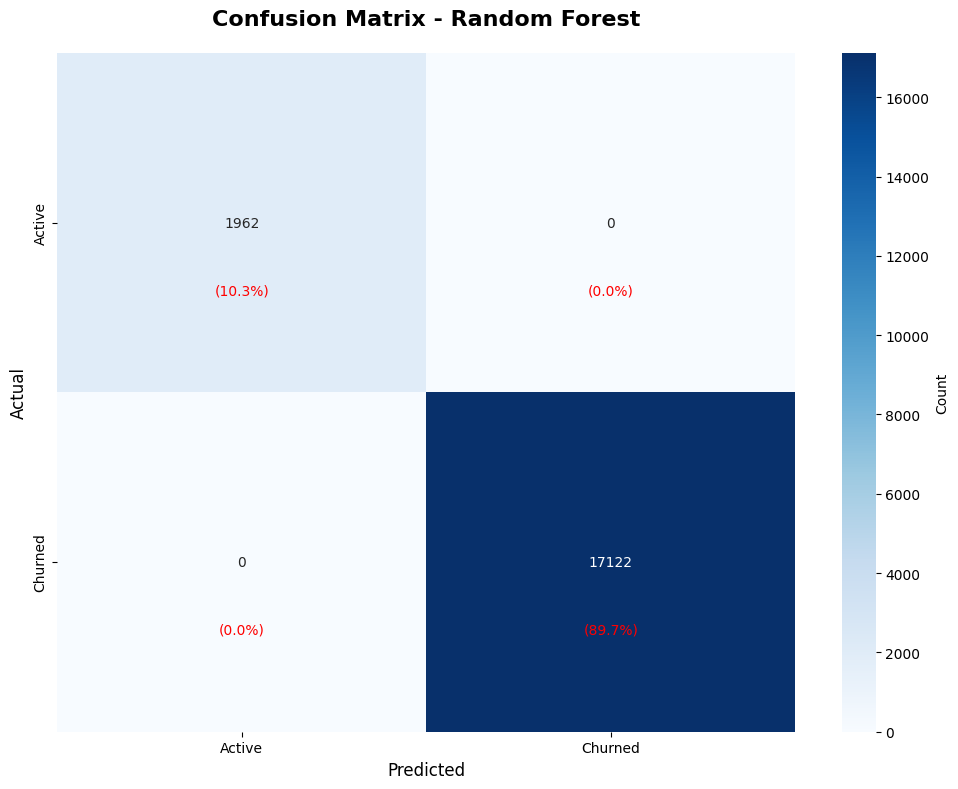


✅ Confusion Matrix saved

📊 Breakdown:
   True Negatives: 1,962 (10.3%)
   False Positives: 0 (0.0%)
   False Negatives: 0 (0.0%)
   True Positives: 17,122 (89.7%)

📈 ROC CURVES


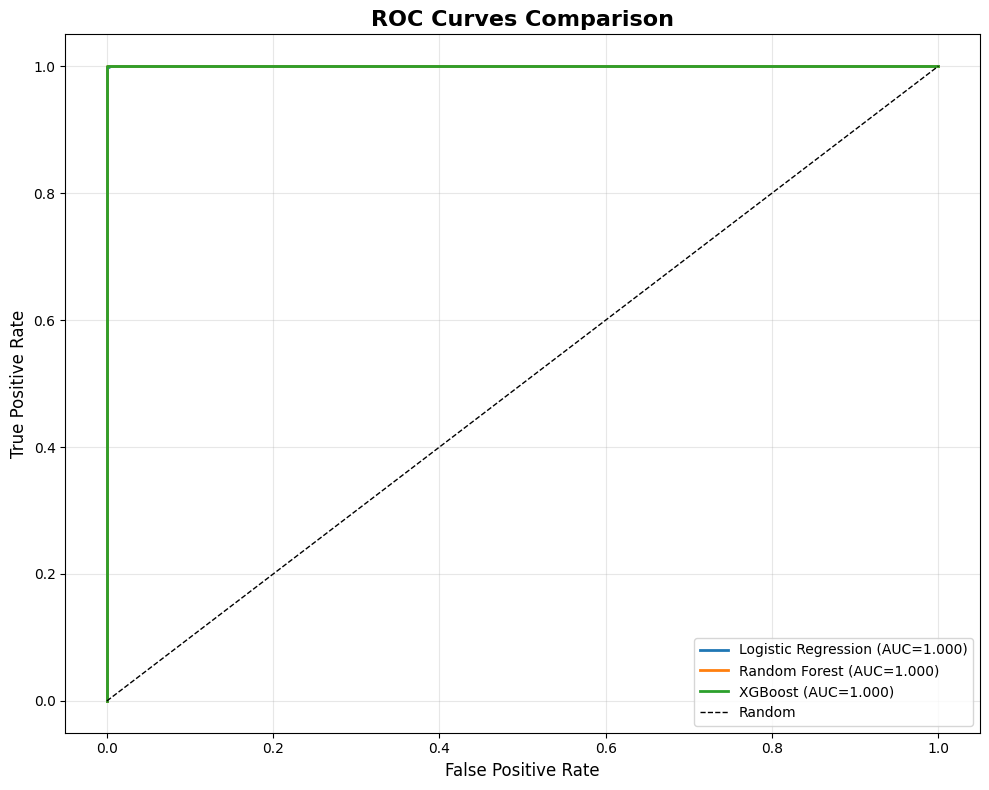


✅ ROC Curves saved

💾 SAVING MODELS

✅ Best model saved: churn_model_random_forest.pkl
✅ Scaler saved: churn_scaler.pkl
✅ Feature names saved
✅ Model comparison saved

✅ MODEL TRAINING COMPLETE!

🏆 Best Model: Random Forest

📊 Performance:
   Accuracy: 1.0000
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000
   ROC-AUC: 1.0000

📁 Saved Files:
   • churn_model_random_forest.pkl
   • churn_scaler.pkl
   • churn_feature_names.pkl
   • churn_confusion_matrix.png
   • churn_roc_curves.png

🎯 Next: Feature Importance Analysis (Cell 6)


In [6]:
print("="*60)
print("🤖 CHURN PREDICTION MODEL TRAINING")
print("="*60)

# Use SMOTE-balanced data
X_train_final = X_train_resampled
y_train_final = y_train_resampled

print(f"\n📊 Training Data:")
print(f"   Samples: {len(X_train_final):,}")
print(f"   Features: {X_train_final.shape[1]}")
print(f"   Class distribution: {dict(pd.Series(y_train_final).value_counts())}")

# ============================================
# 1. BASELINE MODEL - LOGISTIC REGRESSION
# ============================================
print("\n" + "="*60)
print("1️⃣ BASELINE: LOGISTIC REGRESSION")
print("="*60)

# Train model
print("\n⏳ Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_final, y_train_final)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n📊 Performance Metrics:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

# ============================================
# 2. RANDOM FOREST
# ============================================
print("\n" + "="*60)
print("2️⃣ RANDOM FOREST")
print("="*60)

# Train model
print("\n⏳ Training Random Forest (1-2 minutes)...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_final, y_train_final)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n📊 Performance Metrics:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# ============================================
# 3. XGBOOST
# ============================================
print("\n" + "="*60)
print("3️⃣ XGBOOST (Expected Best)")
print("="*60)

# Train model
print("\n⏳ Training XGBoost (2-3 minutes)...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train_final, y_train_final)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n📊 Performance Metrics:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# ============================================
# 4. MODEL COMPARISON
# ============================================
print("\n" + "="*60)
print("📊 MODEL COMPARISON SUMMARY")
print("="*60)

model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ]
})

print("\n" + model_results.round(4).to_string(index=False))

# Find best model
best_model_idx = model_results['F1-Score'].idxmax()
best_model_name = model_results.loc[best_model_idx, 'Model']
best_f1 = model_results.loc[best_model_idx, 'F1-Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

# Select best model objects
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf
else:
    best_model = xgb_model
    y_pred_best = y_pred_xgb
    y_pred_proba_best = y_pred_proba_xgb

# ============================================
# 5. CONFUSION MATRIX
# ============================================
print("\n" + "="*60)
print("📊 CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Active', 'Churned'],
            yticklabels=['Active', 'Churned'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)

# Add percentage
total = cm.sum()
for i in range(2):
    for j in range(2):
        plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('../reports/figures/churn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Confusion Matrix saved")

# Interpret
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Breakdown:")
print(f"   True Negatives: {tn:,} ({tn/len(y_test)*100:.1f}%)")
print(f"   False Positives: {fp:,} ({fp/len(y_test)*100:.1f}%)")
print(f"   False Negatives: {fn:,} ({fn/len(y_test)*100:.1f}%)")
print(f"   True Positives: {tp:,} ({tp/len(y_test)*100:.1f}%)")

# ============================================
# 6. ROC CURVES
# ============================================
print("\n" + "="*60)
print("📈 ROC CURVES")
print("="*60)

plt.figure(figsize=(10, 8))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('D:/Project/DataMining/ecommerce-customer-analytics/reports/figures/churn_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ROC Curves saved")

# ============================================
# 7. SAVE MODELS
# ============================================
print("\n" + "="*60)
print("💾 SAVING MODELS")
print("="*60)

import joblib

# Save best model
model_filename = f'churn_model_{best_model_name.lower().replace(" ", "_")}.pkl'
model_path = f'D:/Project/DataMining/ecommerce-customer-analytics/models/{model_filename}'
joblib.dump(best_model, model_path)
print(f"\n✅ Best model saved: {model_filename}")

# Save scaler
joblib.dump(scaler, 'D:/Project/DataMining/ecommerce-customer-analytics/models/churn_scaler.pkl')
print(f"✅ Scaler saved: churn_scaler.pkl")

# Save feature names
joblib.dump(X_train.columns.tolist(), 'D:/Project/DataMining/ecommerce-customer-analytics/models/churn_feature_names.pkl')
print(f"✅ Feature names saved")

# Save model performance
model_results.to_csv('D:/Project/DataMining/ecommerce-customer-analytics/models/churn_model_comparison.csv', index=False)
print(f"✅ Model comparison saved")

# ============================================
# 8. SUMMARY
# ============================================
print("\n" + "="*60)
print("✅ MODEL TRAINING COMPLETE!")
print("="*60)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"\n📊 Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

print(f"\n📁 Saved Files:")
print(f"   • {model_filename}")
print(f"   • churn_scaler.pkl")
print(f"   • churn_feature_names.pkl")
print(f"   • churn_confusion_matrix.png")
print(f"   • churn_roc_curves.png")

print(f"\n🎯 Next: Feature Importance Analysis (Cell 6)")
print("="*60)